PM shape: (320,), PdM shape: (320,), alpha max: 316

Initializing DE/rand/1/bin optimization...
  Population size (NP): 240
  Parameters (D): 24
  Mutation factor (F): 0.8
  Crossover rate (CR): 0.9
  Max generations: 500
  Generation 1/500: Best fitness = 6.858579
  Generation 50/500: Best fitness = 2.251879
  Generation 100/500: Best fitness = 1.523301
  Generation 150/500: Best fitness = 1.069711
  Generation 200/500: Best fitness = 0.962576
  Generation 250/500: Best fitness = 0.821415
  Generation 300/500: Best fitness = 0.616584
  Generation 350/500: Best fitness = 0.604732
  Generation 400/500: Best fitness = 0.569538
  Generation 450/500: Best fitness = 0.530270
  Generation 500/500: Best fitness = 0.499767

DE Optimization completed!
  Final best fitness: 0.499767
  Total generations: 500

Performance Summary:
  Initial pattern error: 0.739537
  Final pattern error: 0.054728
  Improvement: 0.684810
  Improvement percentage: 92.60%


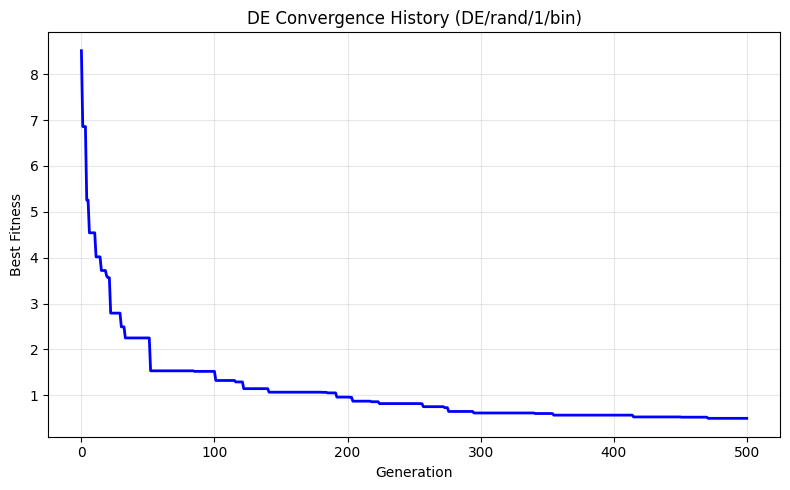

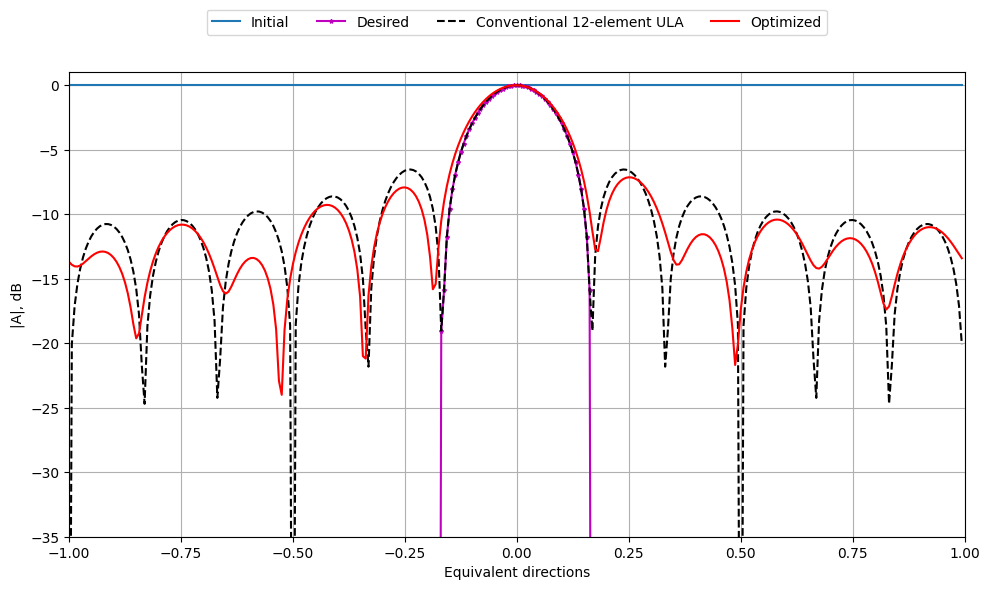

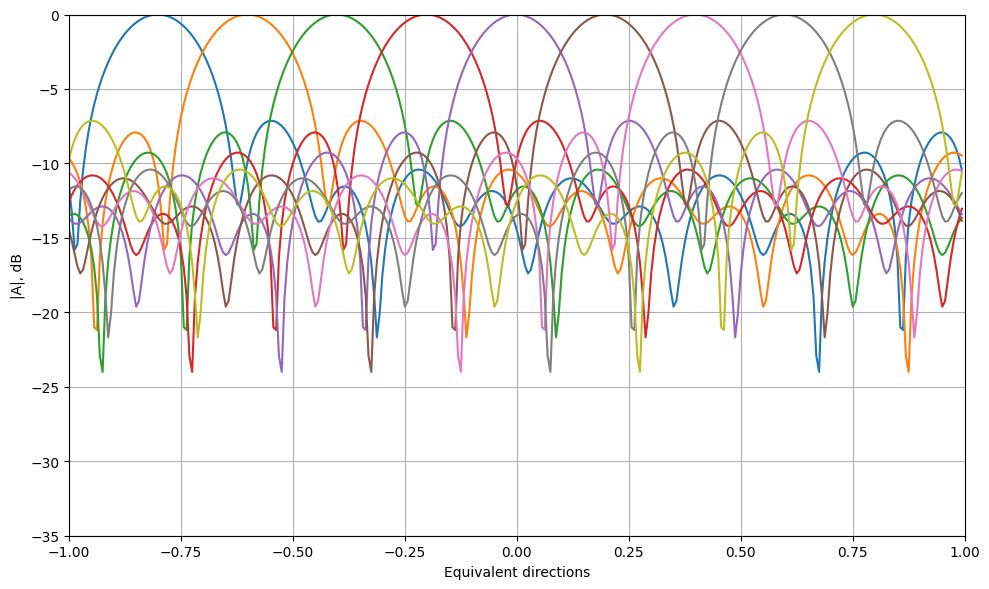

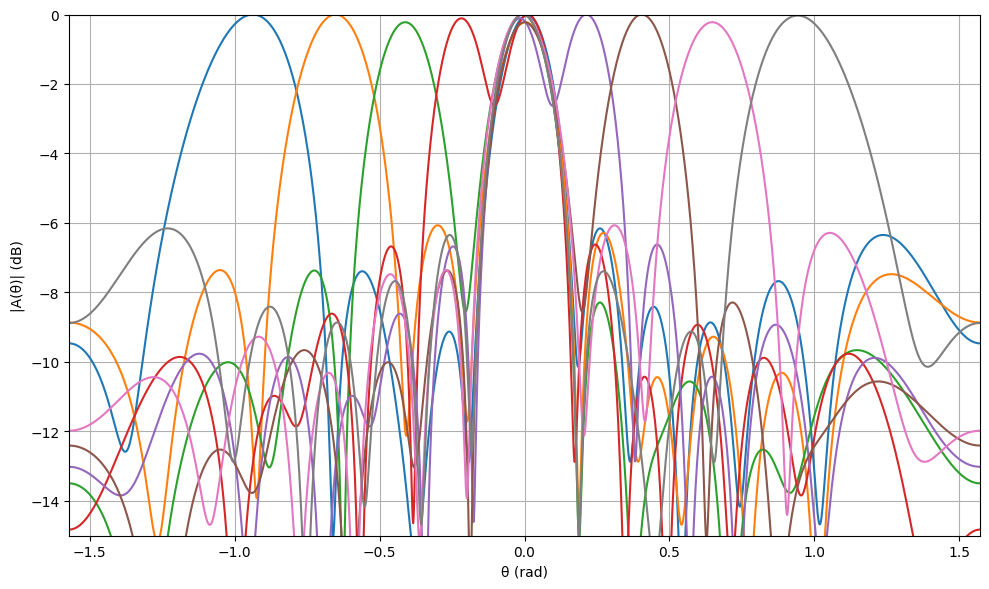

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath(__file__)))

from generateSteeringVector import generateSteeringVector
from generateDesPattern import generateDesPattern
from twoStepILS import twoStepILS
from displacePattern import displacePattern
from generateQuantizedArrResponse import generateQuantizedArrResponse


def main():
    plt.close("all")

    # Variable initialization
    theta = np.deg2rad(np.arange(-90, 90, 0.1))
    lambda_ = 1
    M = 12
    A = generateSteeringVector(theta, M, lambda_)
    desDirs_c = np.array([0.0])
    W_ref = np.zeros((M, len(desDirs_c)), dtype=complex)

    Q = 160
    phi = 1
    eqDir = np.arange(-1, 1, phi / Q)
    Aq = generateQuantizedArrResponse(M, eqDir)

    # Generate desired pattern
    PdM, P_refGen, W0 = generateDesPattern(eqDir, np.sin(desDirs_c[0]), Aq)
    P_init = np.ones_like(eqDir)
    PM = P_init.copy()

    # Indices - sửa để tránh index out of bounds
    alpha1 = np.arange(0, len(eqDir), 4)
    alpha2 = np.where(PdM > 0)[0]
    alpha = np.sort(np.unique(np.concatenate([alpha1, alpha2])))

    # Đảm bảo alpha không vượt quá kích thước
    alpha = alpha[alpha < len(PM)]
    alpha = alpha[alpha < len(PdM)]

    print(f"PM shape: {PM.shape}, PdM shape: {PdM.shape}, alpha max: {alpha.max()}")

    # Optimize
    W_opt = twoStepILS(50, alpha, Aq, W0.reshape(-1, 1), PM, PdM)
    W_ref[:, 0] = W_opt.flatten()

    # Plot optimized beams
    plt.figure(figsize=(10, 6))
    plt.plot(eqDir, np.zeros_like(eqDir), label="Initial")
    plt.plot(
        eqDir,
        10 * np.log10(PdM / np.max(PdM) + 1e-10),
        "m-*",
        label="Desired",
        markersize=3,
    )
    plt.plot(
        eqDir,
        10 * np.log10(P_refGen / np.max(P_refGen) + 1e-10),
        "--k",
        label="Conventional 12-element ULA",
    )

    pattern_opt = np.abs(W_ref.conj().T @ Aq)
    pattern_opt_norm = pattern_opt / np.max(pattern_opt)
    plt.plot(
        eqDir, 10 * np.log10(pattern_opt_norm.flatten() + 1e-10), "r", label="Optimized"
    )

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.xlabel("Equivalent directions")
    plt.ylabel("|A|, dB")
    plt.xlim([-1, 1])
    plt.ylim([-35, 1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Displace the reference beam
    spacing = 0.2
    deltas = np.arange(-0.8, 0.8 + spacing / 2, spacing)
    W_dd = np.zeros((M, len(deltas)), dtype=complex)

    for i in range(len(deltas)):
        W_dd[:, i] = displacePattern(W_ref, deltas[i], M).flatten()

    # Plot displaced beams
    plt.figure(figsize=(10, 6))
    for i in range(len(deltas)):
        pattern = np.abs(W_dd[:, i].conj().T @ Aq)
        plt.plot(eqDir, 10 * np.log10(pattern / np.max(pattern) + 1e-10))

    plt.xlim([-1, 1])
    plt.ylim([-35, 0])
    plt.xlabel("Equivalent directions")
    plt.ylabel("|A|, dB")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Combination of beams
    ro = 0.5
    W_dd = W_dd / np.linalg.norm(W_dd, axis=0, keepdims=True)
    comBeamIdx = len(deltas) // 2

    W_t = np.zeros((M, len(deltas) - 1), dtype=complex)
    j = 0

    for i in range(W_dd.shape[1]):
        if i != comBeamIdx:
            W_t[:, j] = np.sqrt(ro) * W_dd[:, comBeamIdx] + np.sqrt(1 - ro) * W_dd[:, i]
            j += 1

    # Plot combined beams
    plt.figure(figsize=(10, 6))
    for i in range(W_t.shape[1]):
        pattern = np.abs(W_t[:, i].conj().T @ A)
        plt.plot(theta, 10 * np.log10(pattern / np.max(pattern) + 1e-10))

    plt.xlabel("θ (rad)")
    plt.ylabel("|A(θ)| (dB)")
    plt.grid(True)
    plt.xlim([-np.pi / 2, np.pi / 2])
    plt.ylim([-15, 0])
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()